In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
#!pip install timm

In [3]:
class PatchEmbed(nn.Module):
  """ Split image into patches and embed them.

  Parameters
  ----------
  img_size: int 
    Size of image (it is a square; it doesnt have to be)
  patch_size: int 
    Size of the patch (it is a square; it doesnt have to be)
  in_chans: int 
    Number of input channels (for grayscale image it will be 1 input channel; for RGB = 3)
  embed_dim: int
    The positional embedding dimension (How big embedding for each patch.Constant across entire network)

  Attributes
  ----------

  n_patches: int
    Number of patches inside our image.

  proj: nn.Conv2d
    Convolutional layer that does both the splitting into patches and embedding

  """

  def __init__(self, img_size, patch_size, in_chans = 3, embed_dim = 42):
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_patches = (img_size // patch_size)**2

    self.proj = nn.Conv2d(
        in_chans,
        embed_dim,
        kernel_size=patch_size,
        stride=patch_size,
    )
  
  def forward(self,x):
    """ Run forward pass

    Parameters
    -----------
    x: torch.Tensor
      Shape: (n_samples, in_chans, img_size, img_size)

    Returns
    -----------
    torch.Tensor
      Shape: (n_samples, n_patches, embed_dim)
    """

    x = self.proj(
        x
    ) ## (n_samples, embed_dim, n_patches**0.5, n_patches**0.5)
    x = x.flatten(2) # (n_samples, embed_dim, n_patches)
    x = x.transpose(1,2) # (n_samples, n_patches, embed_dim)

    return x

In [4]:
class Attention(nn.Module):
  """ Attention Mechanism

  Parameters
  ----------
  dim: int
    The input and out dimension of per token feature

    n_heads: int
      Number of attention heads 

    qkv_bias: bool
      if true then we include bias to the query, key and value projections

    attn_p: float
      Dropout probability applied to the query, key and value tensors.

    proj_p: float
      Dropout probability applied to output tensor

    
    Attributes
    ----------
    scale: float
      Normalizing constant for the dot product

    qkv: nn.Linear
      Linear projection for the query, key and value

    proj: nn.Linear
      Linear mapping that takes in the concatenated output of all attention
      heads and maps into the new space

    attn_drop, proj_drop: nn.Dropout
      Dropout layers.
  """

  def __init__(self,dim,
               n_heads = 2,
               qkv_bias = True,
               attn_p = 0.,
               proj_p = 0.
               ):
               
    super().__init__()
    self.n_heads = n_heads
    self.dim = dim
    self.head_dim = dim // n_heads
    self.scale = self.head_dim**-0.5

    self.qkv = nn.Linear(dim,dim*3, bias=qkv_bias)
    self.attn_drop = nn.Dropout(attn_p)
    self.proj = nn.Linear(dim,dim)
    self.proj_drop = nn.Dropout(proj_p)

  def forward(self,x):
    ''' Run Forward pass 
    
    Parameters
    ----------
    x: torch.Tensor
      shape: n_samples, n_patches + 1, dim

    Returns
    --------
    torch.Tensor
      shape: n_samples, n_patches + 1, dim
    '''

    n_samples, n_tokens, dim = x.shape

    #print(f'3: Input to the Attention block inside the transformer block: {x.shape}')

    if dim != self.dim:
      raise ValueError

    qkv = self.qkv(x)
    #print(f'4: Output of qkv inside Attention block: {qkv.shape}')
    qkv = qkv.reshape(
        n_samples, n_tokens, 3, self.n_heads, self.head_dim
    ) ## n_samples, n_patches + 1, 3, n_heads, heads_dim

    #print(f'5: qkv reshaped to: {qkv.shape}')

    qkv = qkv.permute(
        2,0,3,1,4
    ) ## 3, n_samples, n_heads, n_patches+1, heads_dim
    q,k,v = qkv[0], qkv[1], qkv[2]
    k_t = k.transpose(-2,-1)  # n_samples, n_heads, head_dim, n_patches+1
    dp = (
        q @ k_t
    ) * self.scale # n_samples, n_heads, n_patches+1, n_patches+1

    attn = dp.softmax(dim = -1) # n_samples, n_heads, n_patches+1, n_patches+1
    attn = self.attn_drop(attn)

    weighted_avg = attn @v # n_samples, n_heads, n_patches+1, head_dim

    weighted_avg = weighted_avg.transpose(
        1,2
    ) # n_samples, n_patches + 1, n_heads, head_dim

    weighted_avg = weighted_avg.flatten(2) # n_samples, n_patches+1, dim

    x = self.proj(weighted_avg) # n_samples, n_patches+ 1, dim
    x = self.proj_drop(x) # n_samples, n_patches+1, dim

    return x


In [5]:

class MLP(nn.Module):
  """ Multilayer perceptron 
  
  Parameters
  ----------

  int_features: int
    Number of input features

  hidden_features: int
    Number of nodes in the hidden layer

  out_features: int
    Number of output features

  p: float
    Dropout probability

  Attribute
  ---------

  fc: nn.Linear
    The first linear layer

  act: nn. GELU
    GELU activation function

  fc2: nn.Linear
    The second linear layer

  drop: nn.Dropout
    Dropout layer
  """

  def __init__(self, in_features, hidden_features, out_features, p = 0.):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_features)
    self.act = nn.GELU()
    self.fc2 = nn.Linear(hidden_features, out_features)
    self.drop = nn.Dropout(p)


  def forward(self,x):
    """ Run forward pass 
    
    Parameters
    ----------
    x: torch.Tensor
      shape: n_samples, n_patches + 1, in_features

    Returns
    ----------
    torch.Tensor
      n_samples, n_patches+ 1, out_features
    
    """
    x = self.fc1(x) # n_samples, n_patches+1, hidden_features
    x = self.act(x) # n_samples, n_patches+1, hidden_features
    x = self.drop(x) # n_samples, n_patches+1, hidden_features
    x = self.fc2(x) # n_samples, n_patches+1, output_features
    x = self.drop(x) # n_samples, n_patches+1, output_features

    return x


In [6]:
class Block(nn.Module):
  """ Transformer block.

  Parameter
  ---------
  dim: int
    embedding dimension

  n_heads: int
    number of attention heads

  mlp_ratio: float
    determines the hidden dimension size of the MLP module with respect to 'dim'

  qkv_bias: bool
    If true then we include bias to the query, key and value projections

  p, attn_p: float
    dropout probability


  Attributes
  ----------
  norm1, norm2: LayerNorm
    Layer normalization

  attn: Attention
    Attention module

  mlp: MLP
    MLP module

  """ 
  def __init__(self, dim, n_heads, mlp_ratio = 4.0, qkv_bias = True, p = 0., attn_p = 0.):
    super().__init__()
    self.norm1 = nn.LayerNorm(dim, eps = 1e-6)
    self.attn = Attention(
        dim,
        n_heads= n_heads,
        qkv_bias = qkv_bias,
        attn_p = attn_p,
        proj_p=p
    )
    self.norm2 = nn.LayerNorm(dim, eps=1e-6)
    hidden_features = int(dim * mlp_ratio)
    self.mlp = MLP(
        in_features=dim,
        hidden_features=hidden_features,
        out_features=dim
    )

  def forward(self,x):
    """ Run Forward pass.
    Parameter
    ---------
    x: torch.Tensor
      shape: n_samples, n_patches + 1, dim

    Returns
    --------
    torch.Tensor
      shape: n_samples, n_patches + 1, dim

    """

    x = x + self.attn(self.norm1(x))
    x = x + self.mlp(self.norm2(x))

    return x


In [7]:
class VisionTransformer(nn.Module):
  """ Simplified implementation of the Vision transformer.

  Parameters
  ----------
  img_size: int
    Both height and width of the image (it is a square)

  patch_size: int
    Both height and width of the patch (it is a square)

  in_chans: int
    Number of input channels

  n_classes: int
    Number of classes

  embed_dim: int
    Dimensionality of the positional token/patch embeddings

  depth: int
    Number of transformer blocks

  n_heads: int
    Number of attention heads

  mlp_ratio: float
    Determine the hidden dimension of the MLP module

  qkv_bias: bool
    If true then we add bias to the query, key and value projections

  p, attn_p: float
    Dropout probability

  
  Attributes
  -----------
  patch_embed: PatchEmbed
    Instance of `PatchEmbed' layer

  cls_token: nn.Parameter
    Learnable parameter that will represent the first token in the sequence.
    It has `embed_dim' elements.
  
  pos_emb: nn.Parameter
    Positional embedding of the cls token + all the patches
    It has (n_patches + 1)*embed_dim elements

  pos_drop: nn.Dropout
    Dropout layer

  blocks: nn.ModuleList
    List of `Block modules'

  norm: nn.Layernorm
    Layer normalization.
  """

  def __init__(self,
               img_size= 32,
               patch_size=8,
               in_chans = 3,
               n_classes = 10,
               embed_dim = 42,
               depth = 3,
               n_heads = 3,
               mlp_ratio = 4,
               qkv_bias = True,
               p=0.,
               attn_p=0.
               ):
    
    super().__init__()
    self.patch_embed = PatchEmbed(
        img_size = img_size,
        patch_size = patch_size,
        in_chans = in_chans,
        embed_dim=embed_dim
    )
    
    self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
    self.pos_embed = nn.Parameter(
        torch.zeros(1,1 + self.patch_embed.n_patches, embed_dim)
    )
    self.pos_drop = nn.Dropout(p=p)
    self.blocks = nn.ModuleList(
        [
         Block(
             dim=embed_dim,
             n_heads=n_heads,
             mlp_ratio=mlp_ratio,
             qkv_bias=qkv_bias,
             p=p,
             attn_p=attn_p,
         )
         for _ in range(depth)
        ]
    )

    self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
    self.head = nn.Linear(embed_dim, n_classes)

  def forward(self,x):
    """ Run the forward pass

    Parameters
    ----------
    x: torch.Tensor
      shape: n_samples, in_chains, img_size, img_size

    Returns
    ---------
    logits: torch.Tensor
      Logits over all the classes: n_samples, n_samples
    """
    #print(f'We are in Vision transformer class with input dim: {x.shape}')

    n_samples = x.shape[0]
    x = self.patch_embed(x)


    cls_token = self.cls_token.expand(
        n_samples, -1, -1
    ) # n_samples, 1, embed_dim

    x = torch.cat((cls_token,x), dim = 1) # n_samples, 1 + n_patches, embed_dim
    x = x + self.pos_embed # n_samples, 1 + n_patches, embed_dim
    x = self.pos_drop(x)

    for block in self.blocks:
      x = block(x)

    x = self.norm(x)

    cls_token_final = x[:,0] # just the cls token (hopefully this encodes entire class info)
    x = self.head(cls_token_final)

    return x
  

## Getting CIFAR10 dataset

In [8]:
train_dataset = torchvision.datasets.CIFAR10(
    root='../../Python Scripts/Datasets/cifar10',
    train=True,
    transform=transforms.ToTensor(),
    download=True)
test_dataset = torchvision.datasets.CIFAR10(
    root='../../Python Scripts/Datasets/cifar10',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Data loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [10]:
for x in train_loader:
  print(x[0].shape)
  print(x[1].shape)
  break

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
# A function to encapsulate the training loop
def batch_gd(model, loss_fn, optimizer, train_loader, test_loader, epochs):
  model.to(device)
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    train_acc = []
    for inputs, targets in train_loader:
      # move data to GPU if available
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      __, out_label = outputs.max(dim=1)
      tr_acc = torch.sum(out_label == targets) / targets.size(0)
      loss = loss_fn(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_acc.append(tr_acc)
      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      __, out_label = outputs.max(dim=1)
      te_acc = torch.sum(out_label == targets) / targets.size(0)
      train_acc.append(te_acc)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {(100*tr_acc):.3f} \
      Test Loss: {test_loss:.4f}, Test Accuracy: {(100*te_acc):.3f}, Duration: {dt}')
  
  return train_losses, test_losses

In [13]:
# Loss and optimizer
model = VisionTransformer(img_size= 32,
                          patch_size=4,
                          in_chans = 3,
                          n_classes = 10,
                          embed_dim = 42,
                          depth = 3,
                          n_heads = 6,
                          mlp_ratio = 4,
                          qkv_bias = True,
                          p=0.,
                          attn_p=0.)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 1.7771, Train Accuracy: 45.000       Test Loss: 1.5038, Test Accuracy: 62.500, Duration: 0:00:29.536418
Epoch 2/15, Train Loss: 1.4219, Train Accuracy: 46.250       Test Loss: 1.3459, Test Accuracy: 56.250, Duration: 0:00:27.159242
Epoch 3/15, Train Loss: 1.3048, Train Accuracy: 56.250       Test Loss: 1.2816, Test Accuracy: 50.000, Duration: 0:00:26.976873
Epoch 4/15, Train Loss: 1.2293, Train Accuracy: 63.750       Test Loss: 1.2236, Test Accuracy: 56.250, Duration: 0:00:27.094395
Epoch 5/15, Train Loss: 1.1756, Train Accuracy: 68.750       Test Loss: 1.1998, Test Accuracy: 37.500, Duration: 0:00:28.078506
Epoch 6/15, Train Loss: 1.1345, Train Accuracy: 53.750       Test Loss: 1.1853, Test Accuracy: 43.750, Duration: 0:00:27.285956
Epoch 7/15, Train Loss: 1.0978, Train Accuracy: 51.250       Test Loss: 1.1719, Test Accuracy: 37.500, Duration: 0:00:27.468043
Epoch 8/15, Train Loss: 1.0639, Train Accuracy: 61.250       Test Loss: 1.1602, Test Accuracy: 43.750, D

KeyboardInterrupt: 

In [15]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

In [ ]:
# Accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  
  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.7045, Test acc: 0.6140


In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[621  24  40  39  18  17  19  27 145  50]
 [ 41 662   9  22   6   8   7  21  73 151]
 [ 70   9 447 133  90 100  99  30  15   7]
 [ 17   7  45 531  38 239  67  26  15  15]
 [ 25   6 103 101 496  80  86  87  14   2]
 [  9   6  43 265  39 552  31  36   9  10]
 [ 10  12  36 115  33  36 727  16   6   9]
 [ 15   6  34  78  56 135  11 628   9  28]
 [ 80  25  13  27   9  10   3   6 794  33]
 [ 35 123  10  28   6  13  16  30  57 682]]


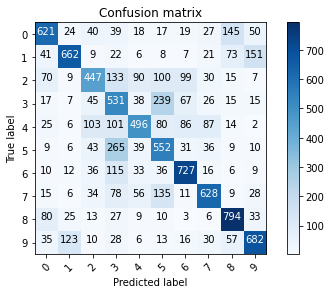

In [ ]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data
y_test = np.array(test_dataset.targets)
p_test = np.array([])
for inputs, targets in test_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [ ]:
# label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

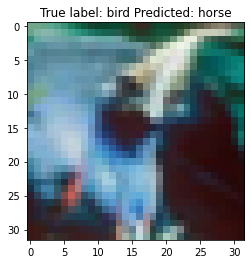

In [ ]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(32,32,3))
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));